## 🎵 MUSDB18 Interactive Audio Exploration Notebook

**Quick Start:**

1. **Create the conda environment:**
   ```bash
   cd "path/to/Final_Project_Deep_Learning"
   conda env create -f environment.yml
   ```

2. **Activate the environment:**
   ```bash
   conda activate final-dl-env
   ```

3. **Open this notebook in Jupyter or VS Code**

4. **Select the Python environment:** When prompted, select `final-dl-env` as the kernel.

5. **Run the first few setup cells, then the Interactive Player cell:**
   - Cell 1: Imports
   - Cell 2: Load MUSDB18
   - Cell 3: Load Track Function
   - **Cell 4: Interactive Player (has song & stem selectors)**
   
   Then you can pick any song and stem without running other cells!

**Features:**
- 🎵 **Pick any song** from 144 tracks in MUSDB18 dataset (or demo audio if ffmpeg unavailable)
- 🎧 **Select any stem**: Mixture, Drums, Bass, Vocals, or Other  
- ▶️ **Play audio directly** in the notebook with one-click control
- 📊 **View waveforms & spectrograms** (optional visualization cells)
- 🔍 **Compare all stems side-by-side** (optional comparison cell)

Just pick a song and stem—that's it!

# MUSDB18 Interactive Audio Exploration
Load, visualize, and listen to music source separation stems with interactive controls.

## Setup and Imports

In [30]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import ipywidgets as widgets
from ipywidgets import interact, interactive
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
%matplotlib inline

print("✓ All imports successful!")

✓ All imports successful!


## Load MUSDB18 Dataset (or Demo Mode)

In [31]:
try:
    import musdb
    print("Loading MUSDB18 dataset...")
    mus = musdb.DB(download=True)
    tracks = mus.tracks
    USE_MUSDB = True
    print(f"✓ Loaded {len(tracks)} tracks from MUSDB18")
except Exception as e:
    print(f"⚠ MUSDB18 not available: {e}")
    print("Generating demo synthetic audio instead...")
    USE_MUSDB = False
    tracks = None

Loading MUSDB18 dataset...
✓ Loaded 144 tracks from MUSDB18


## Load Audio and Create Stems Dictionary

In [32]:
def load_track(track_index=0):
    """Load a track and return stems dictionary.
    
    Args:
        track_index: Index of the track to load (0-143 for 144 available tracks)
    
    Returns:
        stems: Dictionary of audio stems
        sr: Sample rate
        track_info: String with track title, artist, and duration
    """
    if USE_MUSDB and tracks is not None:
        track = tracks[track_index]
        track_info = f"Track: {track.title} by {track.artist}\nDuration: {track.duration:.1f}s"
        
        stems = {
            "Mixture": track.audio,
            "Drums": track.targets["drums"].audio,
            "Bass": track.targets["bass"].audio,
            "Vocals": track.targets["vocals"].audio,
            "Other": track.targets["other"].audio,
        }
        sr = track.rate
    else:
        # Demo mode: synthetic audio
        sr = 22050
        duration = 5
        t = np.linspace(0, duration, int(sr * duration))
        
        mixture = (
            np.sin(2 * np.pi * 440 * t) * 0.3 +
            np.sin(2 * np.pi * 880 * t) * 0.3 +
            np.sin(2 * np.pi * 110 * t) * 0.2
        )
        mixture = np.stack([mixture, mixture], axis=1)  # stereo
        
        stems = {
            "Mixture": mixture,
            "Drums": np.sin(2 * np.pi * 880 * t)[:, np.newaxis] * 0.3,
            "Bass": np.sin(2 * np.pi * 110 * t)[:, np.newaxis] * 0.3,
            "Vocals": np.sin(2 * np.pi * 440 * t)[:, np.newaxis] * 0.3,
            "Other": np.sin(2 * np.pi * 220 * t)[:, np.newaxis] * 0.2,
        }
        track_info = "Demo Mode: Synthetic audio (5 second sine waves)"
    
    return stems, sr, track_info

# Load initial track
stems, sr, _ = load_track(track_index=0)

In [33]:
from IPython.display import clear_output

# Create track selector
if USE_MUSDB and tracks is not None:
    track_names = [f"{i}: {t.title} by {t.artist} ({t.duration:.0f}s)" for i, t in enumerate(tracks)]
else:
    track_names = ["0: Demo Track"]

track_selector = widgets.Dropdown(
    options=track_names,
    value=track_names[0],
    description="Track:"
)

# Create SHARED stem selector (used by all players below)
stem_selector = widgets.Dropdown(
    options=list(stems.keys()),
    value="Mixture",
    description="Stem:"
)

# Output areas
track_output = widgets.Output()
audio_output = widgets.Output()

def load_selected_track(change):
    """Load the selected track and update all stem selectors."""
    track_name = change['new']
    track_idx = int(track_name.split(":")[0])
    
    global stems, sr, stem_selector
    stems, sr, track_info = load_track(track_index=track_idx)
    
    # Update the SHARED stem selector
    new_stem_options = list(stems.keys())
    stem_selector.options = new_stem_options
    stem_selector.value = new_stem_options[0]
    
    with track_output:
        clear_output(wait=True)
        print(track_info)

def play_selected_stem(change):
    """Play the selected stem when dropdown changes."""
    stem_name = change['new']
    
    with audio_output:
        clear_output(wait=True)
        audio = stems[stem_name]
        y_mono = np.mean(audio, axis=1) if audio.ndim > 1 else audio
        y_mono = np.clip(y_mono, -1.0, 1.0)
        
        print(f"▶ Playing: {stem_name}")
        display(Audio(data=y_mono, rate=sr))

track_selector.observe(load_selected_track, names='value')
stem_selector.observe(play_selected_stem, names='value')

# Display initial track info
with track_output:
    _, _, initial_info = load_track(track_index=0)
    print(initial_info)

# All controls in one compact layout
display(widgets.VBox([
    widgets.Label("🎵 Select a Song:"),
    track_selector,
    track_output,
    widgets.HTML("<hr>"),
    widgets.Label("🎧 Select Stem & Play:"),
    stem_selector,
    audio_output
]))

## Waveform Visualization

In [34]:
def plot_waveform(stem_name="Mixture"):
    """Plot waveform for a selected stem."""
    if stem_name not in stems:
        print(f"Available stems: {list(stems.keys())}")
        return
    
    audio = stems[stem_name]
    y_mono = np.mean(audio, axis=1) if audio.ndim > 1 else audio
    
    plt.figure(figsize=(14, 3))
    librosa.display.waveshow(y_mono, sr=sr, color='blue', alpha=0.8)
    plt.title(f"{stem_name} - Waveform", fontsize=14, fontweight='bold')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Waveform plot is defined above - will be called when needed via visualization section below

## Spectrogram Visualization

In [35]:
def plot_spectrogram(stem_name="Mixture"):
    """Plot spectrogram for a selected stem."""
    if stem_name not in stems:
        print(f"Available stems: {list(stems.keys())}")
        return
    
    audio = stems[stem_name]
    y_mono = np.mean(audio, axis=1) if audio.ndim > 1 else audio
    
    D = librosa.stft(y_mono)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    plt.figure(figsize=(14, 5))
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.title(f"{stem_name} - Spectrogram (STFT)", fontsize=14, fontweight='bold')
    plt.colorbar(img, format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Spectrogram plot is defined above - will be called when needed via visualization section below

## Interactive Audio Player with Controls

In [36]:
def interactive_player(stem_name="Mixture"):
    """Interactive player with stem selection."""
    if stem_name not in stems:
        print(f"Available stems: {list(stems.keys())}")
        return
    
    audio = stems[stem_name]
    y_mono = np.mean(audio, axis=1) if audio.ndim > 1 else audio
    y_mono = np.clip(y_mono, -1.0, 1.0)
    
    print(f"🎵 Playing: {stem_name}")
    print(f"Duration: {len(y_mono) / sr:.1f}s")
    
    # Plot waveform
    plt.figure(figsize=(14, 3))
    librosa.display.waveshow(y_mono, sr=sr, color='green', alpha=0.7)
    plt.title(f"{stem_name} - Waveform", fontsize=12)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    # Display player
    return Audio(data=y_mono, rate=sr)

# Create interactive output using the SHARED stem_selector from above
interactive_plot = interactive(
    interactive_player,
    stem_name=stem_selector
)

display(interactive_plot)

interactive(children=(Dropdown(description='Stem:', options=('Mixture', 'Drums', 'Bass', 'Vocals', 'Other'), v…

## All Stems Side By Side

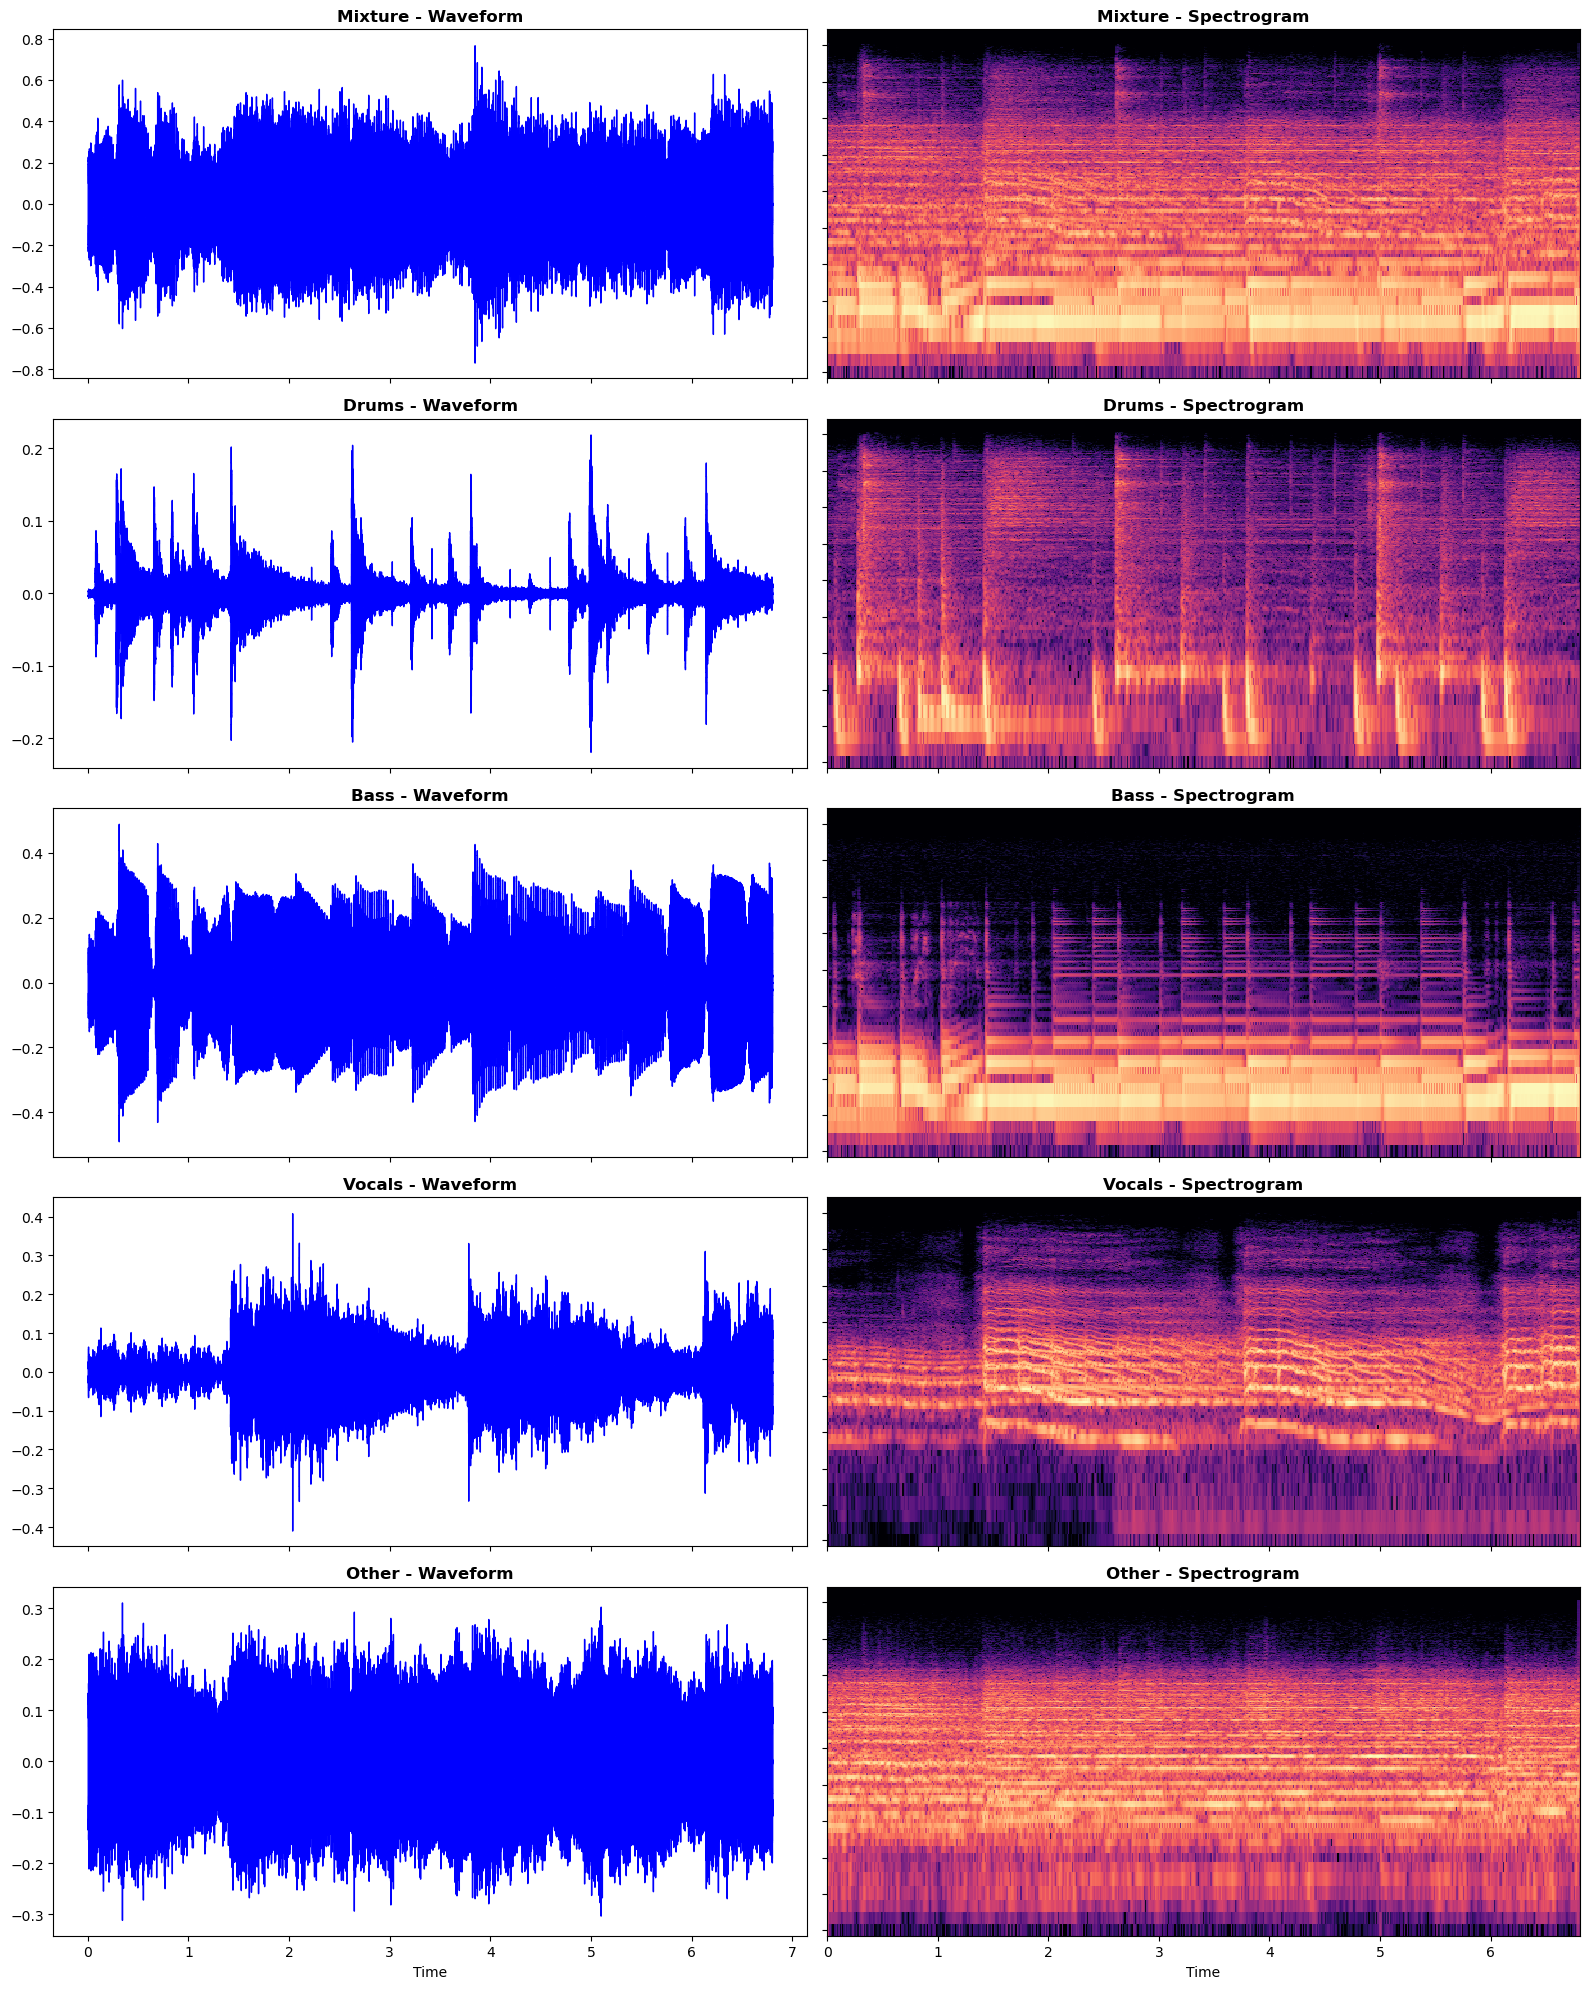

In [37]:
def plot_all_stems():
    """Plot waveforms and spectrograms for all stems."""
    fig, axes = plt.subplots(len(stems), 2, figsize=(16, 4 * len(stems)))
    
    for idx, (stem_name, audio) in enumerate(stems.items()):
        y_mono = np.mean(audio, axis=1) if audio.ndim > 1 else audio
        
        # Waveform
        librosa.display.waveshow(y_mono, sr=sr, ax=axes[idx, 0], color='blue')
        axes[idx, 0].set_title(f"{stem_name} - Waveform", fontweight='bold')
        axes[idx, 0].label_outer()
        
        # Spectrogram
        D = librosa.stft(y_mono)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[idx, 1])
        axes[idx, 1].set_title(f"{stem_name} - Spectrogram", fontweight='bold')
        axes[idx, 1].label_outer()
    
    plt.tight_layout()
    plt.show()

plot_all_stems()